In [1]:
import numpy
import pickle
import h5py
import matplotlib.pyplot as plt
import time
from scipy.ndimage import gaussian_filter
from scipy.optimize import minimize

from sscPimega import pi540D, misc, opt540D

In [ ]:
#pianno = ['annot_20220613_592e35ee.pkl']

pianno = ['annot_20220610_2b1a4ed1.pkl', 'annot_20220613_7ecd0cba.pkl']

start = time.time()

x, optparams, annotation = opt540D.optimize_540D( pianno, 'planar' )

elapsed = time.time() - start

print('Optimization (sec):', elapsed)

In [ ]:
x

In [2]:
#img = h5py.File('template_500mm_003.hdf5','r')['entry/data/data/'][0,0,:,:]

 
img = h5py.File('template_1590mm_001.hdf5','r')['entry/data/data/'][0,0,:,:]

filerings = 'ce02_ema.hdf5'
#filerings = 'LaB6_20220409_25keV_slitopen1mm_24bits_120s_003.hdf5'
#filerings = 'LaB6_New_EMA_1_multiple_test_24bits_600s_035.hdf5'
#filerings = 'LaB6_25keV_slitopen1mm_300mm_24bits_1000s_005.hdf5'
#filerings = 'LaB6_25keV_slitopen1mm_1300mm_24bits_300s_002.hdf5'
#filerings = 'LaB6_25keV_slitopen1mm_500mm_24bits_300s_006.hdf5'

imgrings = h5py.File(filerings,'r')['entry/data/data/'][0,0,:,:]



In [ ]:
if True:
    annot = annotation['annotation']
    track = annotation['track']
    
    imga = opt540D._worker_annotation_image(img)

    img = numpy.clip(img,0,1000)
    imga = numpy.clip(imga,0,1000)

    A = numpy.zeros(img.shape)
    for m in range(len(annot)):
        for k in range(len(annot[m])):
            A[annot[m][k][1], annot[m][k][0] ] = 1 # 2* img.max()
            A[annot[m][k][3], annot[m][k][2] ] = 1 # 2* img.max()

    A = gaussian_filter(A, sigma=2) 
    track = gaussian_filter(track, sigma=2) 

    imga[ A > 0 ] = 1500
     
    img[track > 0] = 1500
    
    plt.figure(figsize=(10,10))
    plt.imshow(imga, cmap='gray_r')
    plt.axis('off')

    plt.figure(figsize=(10,10))
    plt.imshow(img)

In [ ]:
start = time.time()

matchDet = annotation['matchdet']

params  = {'geo':'planar','opt':False, 'mode':'real' }
project = pi540D.get_detector_dictionary(-1, params )
project['s'] = [0,0]
geometry = pi540D.geometry540D( project )

fobj, vmatch = opt540D.tracking540D_planar( project, matchDet)

elapsed = time.time() - start

print( vmatch.astype(int) )
print('Elapsed tracking: (sec)', elapsed)

In [ ]:
V = numpy.zeros( geometry['geom']['shape'][1] )
for k in range(vmatch.shape[0]):
    V[int(vmatch[k][1]), int(vmatch[k][0]) ] = 1 # 2* img.max()  
    V[int(vmatch[k][3]), int(vmatch[k][2]) ] = -1 # 2* img.max()

V = gaussian_filter(V, sigma=10) 

plt.figure(figsize=(10,10))
plt.imshow(V * 1000)

# Optimization

In [ ]:
x

In [ ]:
dic = { 'gaps': numpy.array([[50, 50, 50, 50, 50,0],
                             [50, 50, 50, 50, 50,0],
                             [50, 50, 50, 50, 50,0],
                             [50, 50, 50, 50, 50,0]]).flatten(),
        'oy': numpy.array([[0,0,-4,-4,-2,0],
                          [0,0,0,-4,-4,0],
                          [0,0,-4,0,0,-8],
                          [5,5,5,5,5,0]]).flatten(),
        'ox': numpy.array([[-11,-11,-11,-11,-11,-11],
                           [-12,-12,-12,-12,-12,-12],
                           [-26,-26,-26,-26,-26,-26],
                           [-32,-32,-32,-32,-32,-32]]).flatten()
      }

temparams  = {'geo':'planar','opt':True, 'mode':'real', 'x': dic}


In [ ]:
#template EMA
#/ibira/lnls/labs/ldet/pimega_540D/540d_003_ema/01_calibracao/2021-12-17_geometry/template_1590mm_001.hdf5

#aneis
#/ibira/lnls/beamlines/ema/proposals/20220545/proc/PIMEGA_Comissioning_20220408/CeO2_EMA_1_test_24bits_1800s_slit_0p2_multi_20_003.hdf5

defparams = {'geo':'planar','opt':False, 'mode':'virtual'}

project = pi540D.get_detector_dictionary(0, defparams )
project['s'] = [3,3]

geometry = pi540D.geometry540D( project )

restored1 = pi540D.backward540D( imgrings, geometry )
restored2 = pi540D.backward540D( numpy.clip(imgrings,0,1000), geometry )

#plt.figure(figsize=(20,20))
#plt.imshow(restored1)

soma = restored2 * 1 + 0 * restored1
plt.figure(figsize=(30,30))
#plt.imshow(soma[soma.shape[0]//2-145//2:soma.shape[0]//2+145//2, soma.shape[1]//2-145//2:soma.shape[1]//2+145//2 ])
roi = 300
#plt.imshow(soma[soma.shape[0]//2-roi:soma.shape[0]//2+roi, soma.shape[1]//2-roi:soma.shape[1]//2+roi])
#plt.imshow(soma, cmap='gray_r')
#plt.axis('off')

misc.imshow( imgrings, (20,20))

(3564, 3572)


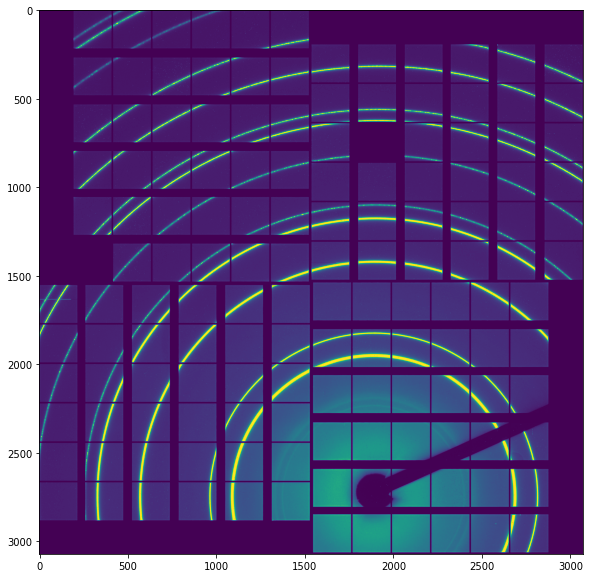

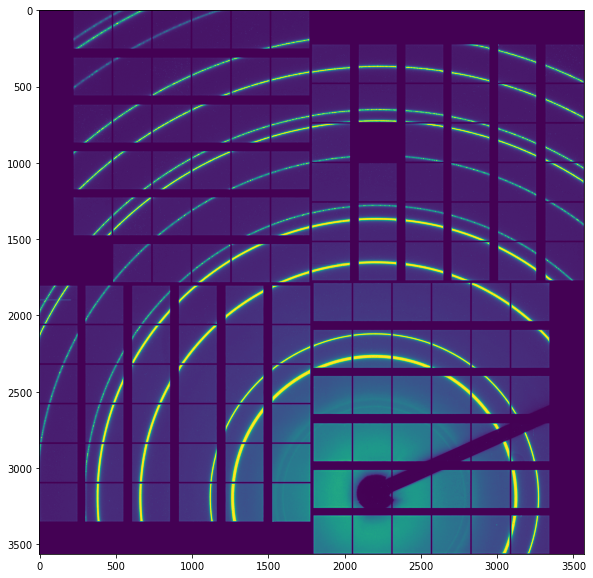

In [4]:
defparams = {'geo':'planar','opt':True, 'mode':'virtual'}

project = pi540D.get_detector_dictionary(0, defparams )
project['s'] = [3,3]

geometry = pi540D.geometry540D( project )

restored = pi540D.backward540D( numpy.clip(imgrings,0,1000), geometry )

plt.figure(figsize=(10,10))
plt.imshow( restored)

defparams = {'geo':'planar','opt':True, 'mode':'real'}

project = pi540D.get_detector_dictionary(0, defparams )
project['s'] = [3,3]

geometry = pi540D.geometry540D( project )

restored2 = pi540D.backward540D( numpy.clip(imgrings,0,1000), geometry )

print(restored2.shape)

plt.figure(figsize=(10,10))
plt.imshow( restored2 )
